# Set environment

In [2]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats

In [3]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-whitegrid")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
#Load experimental data

# Periodic
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic_time, periodic_data = syntheticdata

# Single pulse
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/singlepulse.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
single_time, single_data = syntheticdata

filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/Far1Constant.pickled'
with open(filename, 'rb') as f:
    Far1_arr = pickle.load(f)
Far1_time, Far1_data = Far1_arr

filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/MAPKdata.pickled'
with open(filename, 'rb') as f:
    MAPK_arr = pickle.load(f)
MAPK_time, MAPK_data = MAPK_arr

In [5]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [6]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            if t >= it*p+(p/2) and t < maxs/slope_off+(p)/2+p*it:
                return -slope_off*(t-it*p)+maxs+slope_off*p/2
            else:
                return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            if t >= p and t < maxs/slope_off+(p):
                return -slope_off*(t)+maxs+slope_off*p
            else:
                return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

# Mutant predictions

## Scaling mutants

In [6]:
# Data from constant pheromone experiments
BY68 = [41.15,46.46,51.21,55.46,70.10,89.60,97.08,126.56,153.40,182.97,204.56,218.46,248.84,261.41,281.53,303.74,324.44,347.02,354.07,
        360.24,372.19,380.67,383.79,385.76,389.96,382.62,377.87,390.65,388.34,374.74,382.08,363.26,372.01,342.87,334.88,329.76,321.20,
        310.75,299.50,286.76,281.97,272.27,217.34]
BY169 = [23.49,30.55,34.32,44.78,57.27,81.93,104.19,134.32,148.23,176.16,204.90,221.48,228.84,242.33,257.27,272.73,289.60,301.96,311.96,
         318.18,326.84,329.59,329.62,327.69,324.27,315.42,300.43,295.53,306.53,300.71,282.90,277.80,270.25,261.56,250.88,240.20,223.25,
         216.37,206.33,204.70,189.29,186.19,182.28,170.67,161.30,153.01,146.22]
BY147 = [315.94,323.57,324.97,330.70,337.40,341.69,343.64,358.77,353.62,345.33,343.60,356.63,345.08,329.31,342.26,336.92,337.90,332.45,
         313.74,319.62,314.70,323.94,316.90,328.19,326.34,328.52,329.34,323.29,317.78,317.41,321.27,312.71,317.09,310.97,315.48,311.71,
         307.93,297.87,297.23,301.21,307.97,301.05,303.42,303.47,306.59,297.66,297.17,294.11]

In [7]:
# Load scaled WT data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
scorefxn_time, scorefxn_data = syntheticdata

In [8]:
# Raw single pulse data
BY68_pulse = [0.13,0.12,0.14,0.16,0.17,0.20,0.23,0.28,0.32,0.36,0.41,0.46,0.51,0.55,
            0.62,0.70,0.74,0.78,0.84,0.90,0.96,0.98,0.99,1.02,0.99,0.96,0.96,0.95,0.94,0.90,
            0.87,0.83,0.80,0.76,0.69,0.66,0.64,0.62,0.60,0.58,0.55,0.52,0.51,0.48,0.46,0.43,
            0.43,0.41,0.40,0.37,0.35,0.34,0.32,0.32,0.29,0.27,0.27,0.26,0.25,0.24,0.23]
BY93_pulse = [0.37,0.38,0.40,0.42,0.45,0.48,0.52,0.55,0.58,0.61,0.64,0.69,
            0.71,0.75,0.79,0.81,0.85,0.89,0.92,0.94,0.98,0.98,1.00,1.01,0.99,0.97,0.96,0.94,
            0.92,0.91,0.90,0.90,0.88,0.85,0.83,0.82,0.80,0.77,0.75,0.73,0.71,0.67,0.66,0.63,
            0.60,0.59,0.58,0.55,0.55,0.53,0.53,0.51,0.50,0.49,0.49,0.47,0.46,0.46,0.45,0.44,
            0.44]
BY103_pulse = [0.35,0.36,0.39,0.41,0.42,0.47,0.50,0.54,0.58,0.60,0.64,0.68,0.72,0.75,0.80,0.83,
             0.87,0.90,0.94,0.99,1.01,1.00,0.99,0.99,1.01,0.97,0.96,0.95,0.92,0.90,0.89,0.87,
             0.85,0.84,0.82,0.79,0.77,0.77,0.74,0.73,0.71,0.70,0.69,0.66,0.65,0.63,0.61,0.59,
             0.59,0.58,0.56,0.54,0.53,0.52,0.51,0.50,0.49,0.47,0.46,0.45,0.45]
BY110_pulse = [0.19,0.20,0.22,0.25,0.28,0.32,0.36,0.39,0.44,0.49,0.53,0.58,0.64,0.68,0.72,0.77,
             0.82,0.87,0.92,0.96,0.98,1.00,1.00,1.00,0.98,0.95,0.94,0.91,0.90,0.86,0.84,0.81,
             0.79,0.75,0.72,0.69,0.68,0.66,0.63,0.62,0.60,0.57,0.55,0.53,0.52,0.50,0.50,0.47,
             0.46,0.45,0.43,0.42,0.41,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.32]
BY130_pulse = [0.37,0.39,0.39,0.42,0.45,0.52,0.57,0.61,0.65,0.70,0.73,0.78,0.81,
             0.85,0.88,0.89,0.92,0.96,0.97,1.01,0.99,1.00,0.98,0.96,0.96,0.92,0.87,0.86,0.82,
             0.81,0.80,0.76,0.74,0.74,0.72,0.70,0.68,0.67,0.66,0.66,0.64,0.64,0.60,0.60,0.59,
             0.57,0.57,0.54,0.54,0.53,0.53,0.52,0.50,0.49,0.48,0.47,0.47,0.47,0.46,0.45,0.44]
BY147_pulse = [0.83,0.84,0.85,0.86,0.88,0.87,0.88,0.90,0.87,0.89,0.92,0.93,0.94,0.94,
             0.94,0.96,0.99,1.02,0.99,1.02,1.01,1.01,1.00,0.97,0.97,1.00,1.01,1.02,1.00,0.99,
             0.99,1.01,1.00,0.98,0.98,0.95,0.95,0.95,0.91,0.93,0.93,0.88,0.88,0.85,0.85,0.88,
             0.85,0.84,0.83,0.83,0.82,0.82,0.80,0.78,0.79,0.78,0.79,0.78,0.76,0.76,0.74]
BY169_pulse = [0.20,0.20,0.22,0.24,0.27,0.31,0.35,0.40,0.46,0.50,0.54,0.59,0.64,0.70,
             0.73,0.78,0.83,0.87,0.92,0.95,0.99,1.00,0.99,0.99,0.96,0.96,0.92,0.92,0.89,0.86,
             0.83,0.79,0.76,0.75,0.70,0.68,0.65,0.62,0.61,0.58,0.56,0.55,0.53,0.52,0.49,0.48,
             0.46,0.44,0.43,0.41,0.40,0.38,0.37,0.36,0.35,0.35,0.33,0.33,0.31,0.31,0.30]

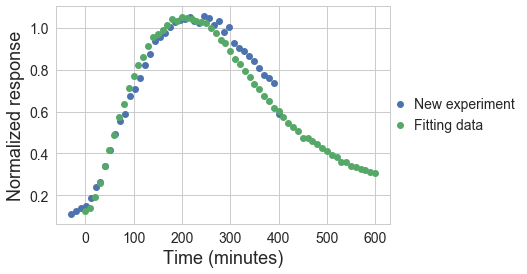

In [9]:
# Scale WT experimental data to scaled data
shift = -30
factor = 0.0027
time_BY68 = np.linspace(0+shift,430+shift,43)
BY68_scaled = []
for i in BY68: BY68_scaled.append(i*factor)

plt.plot(time_BY68,BY68_scaled,'o')
plt.plot(scorefxn_time[0],scorefxn_data[0],'o')

err = 0
for i in range(43):
    err+=(scorefxn_data[0][i]-BY68_scaled[i])**2
plt.legend(['New experiment','Fitting data'],loc='center left', bbox_to_anchor=(0.95, 0.5),handletextpad=0.01)
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized response')
bbox = matplotlib.transforms.Bbox([[-0.15, -0.1], [7.2, 4]])

plt.savefig('Scaling WT.png',dpi = 600,bbox_inches =bbox)

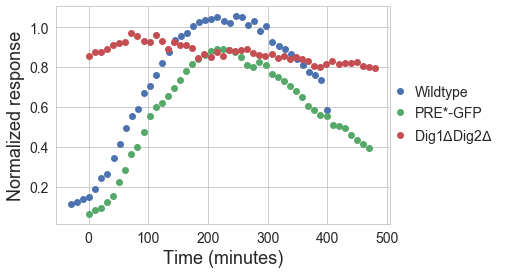

In [10]:
# Scaled constant mutants
factor = 0.0027

BY169_scaled = []
for i in BY169: BY169_scaled.append(i*factor)
    
BY147_scaled = []
for i in BY147: BY147_scaled.append(i*factor)

time_BY169 = np.linspace(0,len(BY169)*10,len(BY169))
time_BY147 = np.linspace(0,len(BY147)*10,len(BY147))
plt.plot(time_BY68,BY68_scaled,'o')
plt.plot(time_BY169,BY169_scaled,'o')
plt.plot(time_BY147,BY147_scaled,'o')
plt.legend(['Wildtype','PRE*-GFP','Dig1$\Delta$Dig2$\Delta$'],loc='center left', bbox_to_anchor=(0.95, 0.5),handletextpad=0.01)
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized response')
plt.savefig('Constant Mutants.png',dpi = 600,bbox_inches =bbox)

In [11]:
# Mutated promoter
ninety_ten = np.linspace(0,90,10)
ninety_five = np.linspace(0,90,19)
factor = 0.44
BY169_pulse_scaled = []
for i in BY169_pulse: BY169_pulse_scaled.append(i*factor)

# plt.plot(ninety_ten,BY169_scaled[0:10])
# plt.plot(ninety_five,BY169_pulse_scaled[0:19])

# err = 0
# for i in range(9):
#     err+=(BY169_pulse_scaled[i*2]-BY169_scaled[i])**2
# err

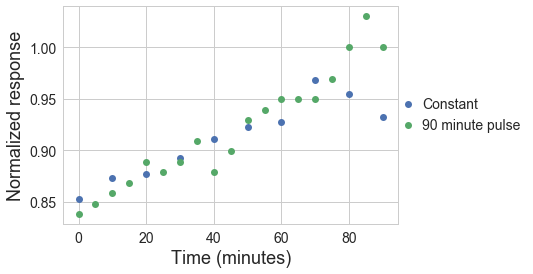

In [12]:
# Digs
ninety_ten = np.linspace(0,90,10)
ninety_five = np.linspace(0,90,19)
factor = 1.01
BY147_pulse_scaled = []
for i in BY147_pulse: BY147_pulse_scaled.append(i*factor)

plt.plot(ninety_ten,BY147_scaled[0:10],'o')
plt.plot(ninety_five,BY147_pulse_scaled[0:19],'o')
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized response')
plt.legend(['Constant','90 minute pulse'],loc='center left', bbox_to_anchor=(0.95, 0.5),handletextpad=0.01)
plt.savefig('Normalized DigDD.png',dpi = 600,bbox_inches =bbox)

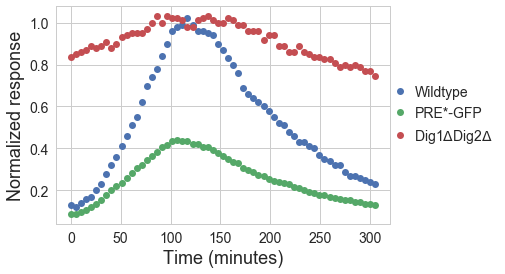

In [13]:
# Scaled single pulse mutants
plt.plot(np.linspace(0,len(BY68_pulse)*5,len(BY68_pulse)),BY68_pulse,'o')
plt.plot(np.linspace(0,len(BY169_pulse_scaled)*5,len(BY169_pulse_scaled)),BY169_pulse_scaled,'o')
plt.plot(np.linspace(0,len(BY147_pulse_scaled)*5,len(BY147_pulse_scaled)),BY147_pulse_scaled,'o')
plt.legend(['Wildtype','PRE*-GFP','Dig1$\Delta$Dig2$\Delta$'],loc='center left', bbox_to_anchor=(0.95, 0.5),handletextpad=0.01)
plt.xlabel('Time (minutes)')
plt.ylabel('Normalized response')
plt.savefig('Pulse Mutants.png',dpi = 600,bbox_inches =bbox)

## Old model predictions

In [14]:
# Required functions
def DE(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
def signal(signal_number,t,slope_on,slope_off):
    p = 180
    if (90)*slope_on < 1:
        maxs = (90)*slope_on
    else:
        maxs = 1

    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else:
        it = 0
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else: 
            if t >= it*p+(p/2) and t < maxs/slope_off+(p)/2+p*it:
                return -slope_off*(t-it*p)+maxs+slope_off*p/2
            else:
                return 0
    
def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

In [15]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180703_AllData_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,1.115)
arrT_best_inds = arr_best_inds.transpose()

Loaded 64 files (out of 1288) with cutoff score of 1.115


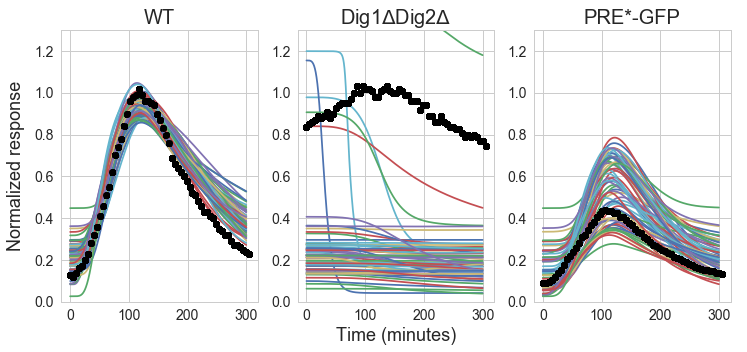

In [16]:
#Specify Figure
hc =2
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3)
ax11 = fig.add_subplot(gs[0,0])
ax31 = fig.add_subplot(gs[0,1])
ax32 = fig.add_subplot(gs[0,2])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized response')
ax.grid('off')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)
kdegS12D = 0

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)

for j in range(len(arr_best_inds[:,gen])):
    for i in range(7):
        expX = 0
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds[j][gen]
        if i == 0:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = odeint(DE, IC, t, args=(0,100,100,))
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax11.plot(t1,expX[:,0])
            ax11.plot(np.linspace(0,len(BY68_pulse)*5,len(BY68_pulse)),BY68_pulse,'ko')
            ax11.set_title('WT')
            ax11.set_ylim([0,1.3])
        elif i == 5:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, 0, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax31.plot(t1,expX[:,0])
            ax31.plot(np.linspace(0,len(BY147_pulse_scaled)*5,len(BY147_pulse_scaled)),BY147_pulse_scaled,'ko')
            ax31.set_title('Dig1$\Delta$Dig2$\Delta$')
            ax31.set_ylim([0,1.3])
        elif i == 6:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP*3.33, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax32.plot(t1,expX[:,0])
            ax32.plot(np.linspace(0,len(BY169_pulse_scaled)*5,len(BY169_pulse_scaled)),BY169_pulse_scaled,'ko')
            ax32.set_title('PRE*-GFP')
            ax32.set_ylim([0,1.3])
fig.savefig('Old Model Predictions.png',dpi=600)

## New model predictions

In [17]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181025_AllDatav2_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,1.0802)
arrT_best_inds = arr_best_inds.transpose()

Loaded 32 files (out of 1274) with cutoff score of 1.0802


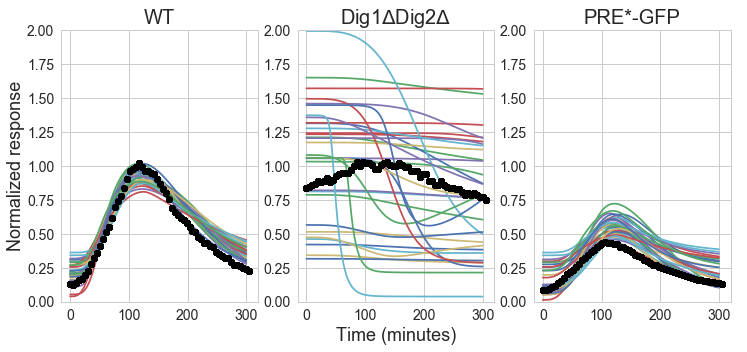

In [18]:
#Specify Figure
hc =2
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3)
ax11 = fig.add_subplot(gs[0,0])
ax31 = fig.add_subplot(gs[0,1])
ax32 = fig.add_subplot(gs[0,2])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized response')
ax.grid('off')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)

for j in range(len(arr_best_inds[:,gen])):
    for i in range(7):
        expX = 0
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
        if i == 0:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = odeint(DE, IC, t, args=(0,100,100,))
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax11.plot(t1,expX[:,0])
            ax11.plot(np.linspace(0,len(BY68_pulse)*5,len(BY68_pulse)),BY68_pulse,'ko')
            ax11.set_title('WT')
            ax11.set_ylim([0,2])
        elif i == 5:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, 0, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax31.plot(t1,expX[:,0])
            ax31.plot(np.linspace(0,len(BY147_pulse_scaled)*5,len(BY147_pulse_scaled)),BY147_pulse_scaled,'ko')
            ax31.set_title('Dig1$\Delta$Dig2$\Delta$')
            ax31.set_ylim([0,2])
        elif i == 6:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP*3.33, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax32.plot(t1,expX[:,0])
            ax32.plot(np.linspace(0,len(BY169_pulse_scaled)*5,len(BY169_pulse_scaled)),BY169_pulse_scaled,'ko')
            ax32.set_title('PRE*-GFP')
            ax32.set_ylim([0,2])
fig.savefig('New Model Predictions.png',dpi=600)

### Subset good fitting parameter sets

In [19]:
# Define Digs score function
time = np.linspace(0,len(BY147_pulse_scaled)*5-5,len(BY147_pulse_scaled))
def scorefxn1(scorefxn_time, scorefxn_data, arr_parameters, time, plot_bool):
    mse_total = 0
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12 = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    DigsT = 0
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    # loop through different periods 
    signal_numbers = [1,90,120,150,180,240,320]
    expX = simulate_single_experiment1(arr_parameters, time, 90,SS)

    # get index of time points closest 
    idx_closest_time_points = []
    for each_time in scorefxn_time:
        closest_idx = min(range(len(time)), 
                          key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)

    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]

    #SCORE IT! using MSE
    expX_mse = (abs(BY147_pulse_scaled - expX_scorefxn_data[:,0])).mean()
    #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
    mse_total += expX_mse

    #plot for visualization:
    if plot_bool == True:
        plt.plot(time,expX, color='green', alpha=0.5)
        
    return mse_total

In [20]:
#Calculate Digs error and set threshold (33%)
hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)

scores = []

for j in range(len(arr_best_inds[:,gen])):
    expX = 0
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
    curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, 0, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    SS=odes[100000,:]
    expX = simulate_single_experiment1(curr_params, t1, 90,SS)
    scores.append(scorefxn1(time, BY147_pulse_scaled, curr_params, time, False))
    
# Determine threshold for good scores
scores_bool = []
for i in scores:
    if i < 0.26:
        scores_bool.append(1)
    else:
        scores_bool.append(0)
print(sum(scores_bool)/len(scores_bool))
digs_scores = scores_bool

0.34375


In [21]:
# Define PRE score function
time = np.linspace(0,len(BY169_pulse_scaled)*5-5,len(BY169_pulse_scaled))
def scorefxn1(scorefxn_time, scorefxn_data, arr_parameters, time, plot_bool):
    mse_total = 0
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12 = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    KGFP = KGFP*3.33
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    # loop through different periods 
    signal_numbers = [1,90,120,150,180,240,320]
    expX = simulate_single_experiment1(arr_parameters, time, 90,SS)

    # get index of time points closest 
    idx_closest_time_points = []
    for each_time in scorefxn_time:
        closest_idx = min(range(len(time)), 
                          key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)

    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]

    #SCORE IT! using MSE
    expX_mse = (abs(BY169_pulse_scaled - expX_scorefxn_data[:,0])).mean()
    #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
    mse_total += expX_mse

    #plot for visualization:
    if plot_bool == True:
        plt.plot(time,expX, color='green', alpha=0.5)
        
    return mse_total

In [22]:
# Calculate PRE error and set threshold (33%)
hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)

scores = []

for j in range(len(arr_best_inds[:,gen])):
    expX = 0
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
    curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP*3.33, KFus3, KSte12, KFar1,kdegS12D
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    SS=odes[100000,:]
    expX = simulate_single_experiment1(curr_params, t1, 90,SS)
    scores.append(scorefxn1(time, BY169_pulse_scaled, curr_params, time, False))
    
# Determine threshold for good scores
scores_bool = []
for i in scores:
    if i < 0.0605:
        scores_bool.append(1)
    else:
        scores_bool.append(0)
print(sum(scores_bool)/len(scores_bool))
pre_scores = scores_bool

0.34375


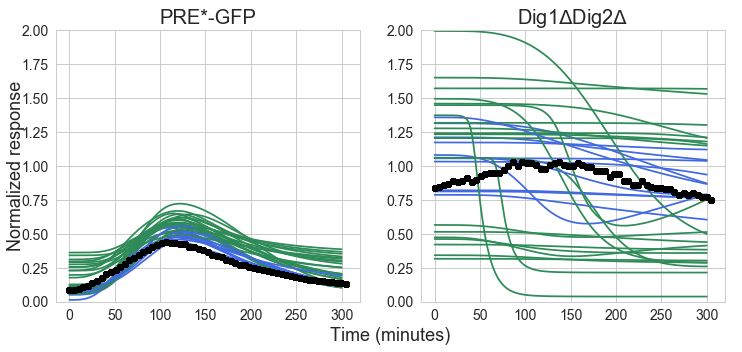

In [23]:
#Specify figure comparing good and bad parameters
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized response')
ax.grid('off')

hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)

for j in range(len(arr_best_inds[:,gen])):
    expX = 0
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
    curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP*3.33, KFus3, KSte12, KFar1,kdegS12D
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    SS=odes[100000,:]
    expX = simulate_single_experiment1(curr_params, t1, 90,SS)
    if pre_scores[j]==1:
        ax1.plot(t1,expX[:,0],'royalblue')
    else:
        ax1.plot(t1,expX[:,0],'seagreen')
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
    curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, 0, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
    odes = simulate_single_experiment1(curr_params, t, 0, IC)
    SS=odes[100000,:]
    expX = simulate_single_experiment1(curr_params, t1, 90,SS)
    if digs_scores[j]==1:
        ax2.plot(t1,expX[:,0],'royalblue')
    else:
        ax2.plot(t1,expX[:,0],'seagreen')
    ax1.plot(np.linspace(0,len(BY169_pulse_scaled)*5,len(BY169_pulse_scaled)),BY169_pulse_scaled,'ko')
    ax2.plot(np.linspace(0,len(BY147_pulse_scaled)*5,len(BY147_pulse_scaled)),BY147_pulse_scaled,'ko')
    ax1.set_ylim([0,2])
    ax2.set_ylim([0,2])
    ax1.set_title('PRE*-GFP')
    ax2.set_title('Dig1$\Delta$Dig2$\Delta$')
fig.savefig('Top third of predictions.png',dpi=600)

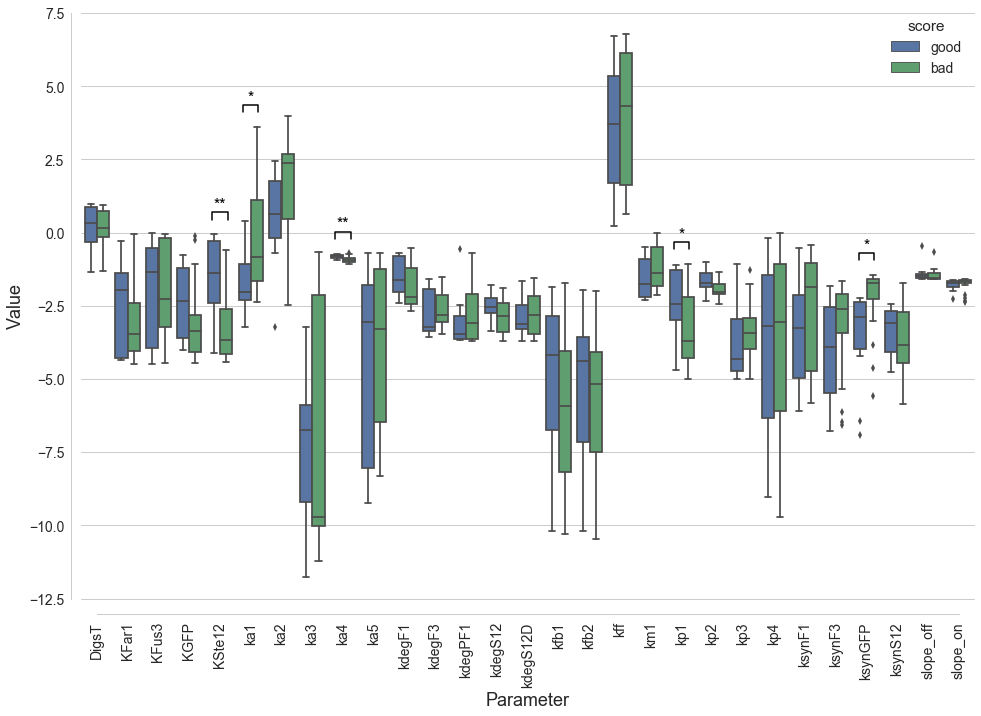

In [137]:
# plot box plot comparing parameter sets for PRE

labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']

d = []
e = []
arr_best_inds_P=arr_best_inds
for i in range(len(arr_best_inds_P)):
    if pre_scores[i]==1:
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    else:
        e.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    

swarm_params_good = pd.DataFrame(d)
swarm_params_bad = pd.DataFrame(e)

unstacked_good = swarm_params_good.unstack().reset_index() 
unstacked_good.columns = ['Parameter', 'index', 'Value']

unstacked_bad = swarm_params_bad.unstack().reset_index() 
unstacked_bad.columns = ['Parameter', 'index', 'Value']

# Get p-valuses
p_vals = []
for i in swarm_params_good.columns:
    p_vals.append(stats.ttest_ind(swarm_params_good[i],swarm_params_bad[i])[1])
    
# Create comparison data frame
compare = pd.concat([unstacked_good, unstacked_bad], keys=['good', 'bad'])
compare = compare.reset_index();
compare = compare.rename(columns={'level_0':'score'})

# Make a box plot comparing parameter sets
fig = plt.figure(figsize=(16, 11))
g=sns.boxplot(x="Parameter", y="Value",
            hue="score", data=compare);
for i in range(len(p_vals)):
    if p_vals[i] < 0.001:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.01:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.05:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 16)
sns.despine(offset=10, trim=True)
g.set_xticklabels(labelnames,rotation=90);
fig.savefig('PRE box.png',dpi = 600)

In [ ]:
# plot box plot comparing parameter sets for PRE

labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']

d = []
e = []
arr_best_inds_P=arr_best_inds
for i in range(len(arr_best_inds_P)):
    if digs_scores[i]==1:
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    else:
        e.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    

swarm_params_good = pd.DataFrame(d)
swarm_params_bad = pd.DataFrame(e)

unstacked_good = swarm_params_good.unstack().reset_index() 
unstacked_good.columns = ['Parameter', 'index', 'Value']

unstacked_bad = swarm_params_bad.unstack().reset_index() 
unstacked_bad.columns = ['Parameter', 'index', 'Value']

# Get p-valuses
p_vals = []
for i in swarm_params_good.columns:
    p_vals.append(stats.ttest_ind(swarm_params_good[i],swarm_params_bad[i])[1])
    
# Create comparison data frame
compare = pd.concat([unstacked_good, unstacked_bad], keys=['good', 'bad'])
compare = compare.reset_index();
compare = compare.rename(columns={'level_0':'score'})

# Make a box plot comparing parameter sets
fig = plt.figure(figsize=(16, 11))
g=sns.boxplot(x="Parameter", y="Value",
            hue="score", data=compare);
for i in range(len(p_vals)):
    if p_vals[i] < 0.001:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.01:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.05:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 16)
sns.despine(offset=10, trim=True)
g.set_xticklabels(labelnames,rotation=90);
fig.savefig('Digs box.png',dpi = 600)

In [147]:
unstacked_good[unstacked_good['Parameter']==' ksynGFP']['Value'].max()

-2.244358033973521

# New model fits

In [26]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181025_AllDatav2_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.0802)
arrT_best_inds_P = arr_best_inds_P.transpose()

Loaded 32 files (out of 1274) with cutoff score of 1.0802


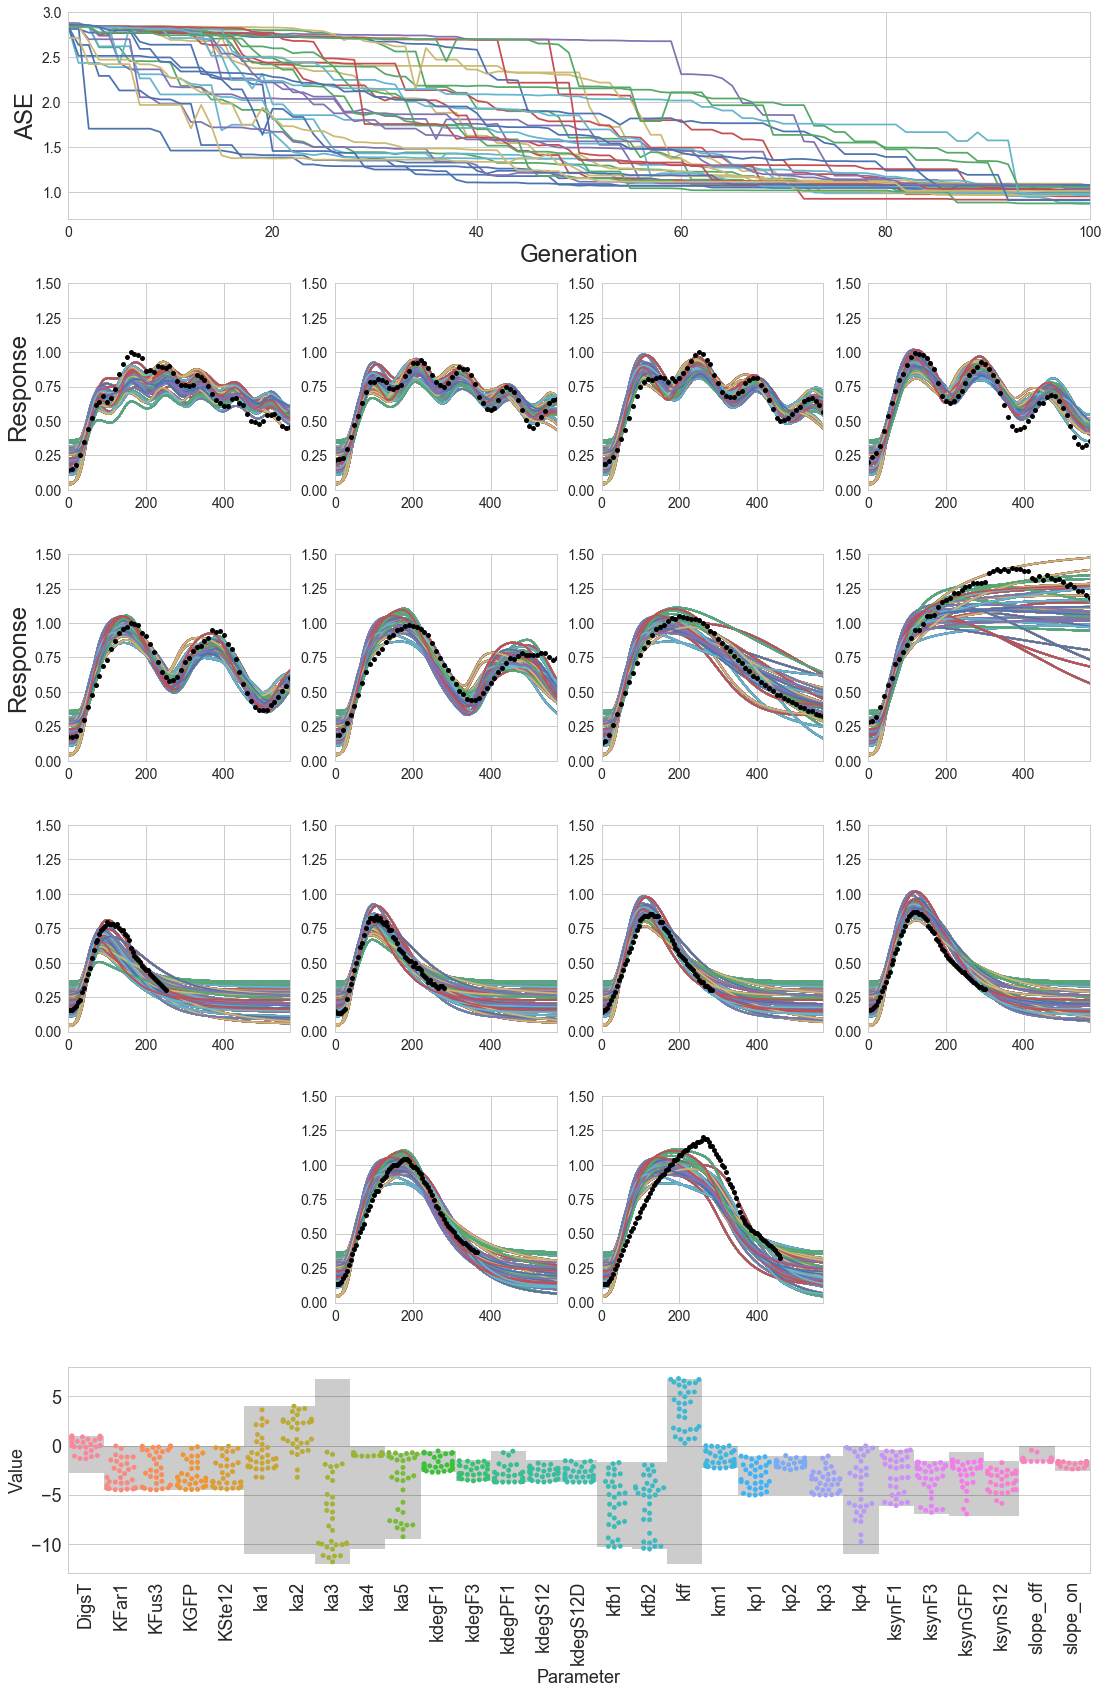

In [27]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2],  
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    ax1.set_ylim([0.7,3.0])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
fig.savefig('New Model top 2.5.png',dpi = 600)


## MAPK phosphorylation predictions

In [12]:
# Import MAPK data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/MAPKdata.pickled'
with open(filename, 'rb') as f:
    MAPK_arr = pickle.load(f)
MAPK_time, MAPK_data = MAPK_arr
# Data from Nicky 
data_45 = [0.178573428,0.755987678,1.416514368,2.275058421,1.743047812,0.461616261,0.158728478,0.12657877,0.349453669,0.472709938]
data_45_norm= [0.078491799,0.332293743,0.622627689,1,0.766155188,0.202903036,0.069768968,0.055637591,0.153602064,0.207779252]
time_45 = [0,15.7,30.3,44.9,47,50.3,52.7,55.7,60,65.3]
data_90_norm = []
for i in MAPK_data[1]: data_90_norm.append(i/0.86)

In [28]:
#DEFINE STEADY STATE - WT
SS=[]
for j in range(len(arr_best_inds_P[:,gen])):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

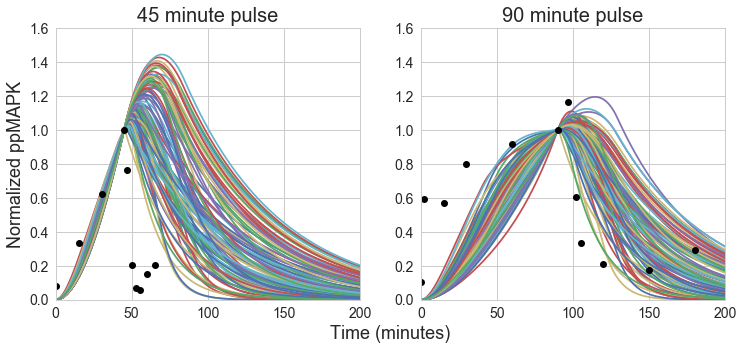

In [29]:
# Plot MAPK profiles
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized ppMAPK')
ax.grid('off')

maxs = []
for j in range(len(arr_best_inds_P[:,gen])):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    for i in [45,90]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time,i,SS[j])
        if i == 45:
            ax1.plot(time, expX[:,2]/expX[45,2])
            maxs.append(max(expX[:,2]/expX[45,2]))
        else: 
            ax2.plot(time, expX[:,2]/expX[90,2])

ax1.set_ylim([0,1.6])
ax2.set_ylim([0,1.6])
ax1.set_xlim([0,200])
ax2.set_xlim([0,200])
ax1.set_title('45 minute pulse')
ax2.set_title('90 minute pulse')


# plot things
ax2.plot(np.array(MAPK_time[1]),data_90_norm,'ko')
ax1.plot(time_45,data_45_norm,'ko')

fig.savefig('MAPK profiles.png',dpi=600)

In [34]:
# Look at parameter sets with max MAPK <= 1.05
MAPK_bool = []
for i in range(len(maxs)):
    if maxs[i]<=1.05:
        MAPK_bool.append(1)
    else:
        MAPK_bool.append(0)

(0, 200)

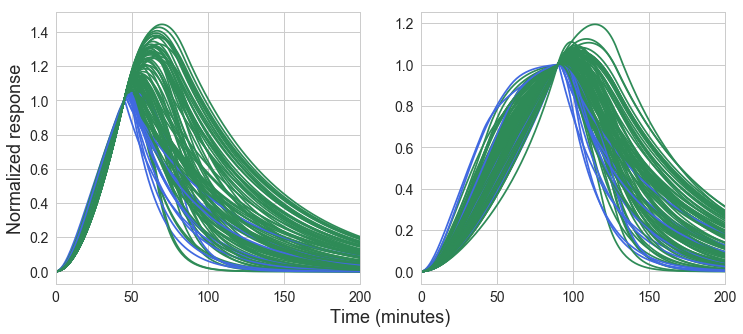

In [35]:
#Specify figure comparing good and bad parameters
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Normalized response')
ax.grid('off')

hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)

for j in range(len(arr_best_inds_P[:,gen])):
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
    for i in [45,90]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time,i,SS[j])
        if i == 45:
            if MAPK_bool[j] == 1:
                ax1.plot(time, expX[:,2]/expX[45,2],'royalblue' )
            else:
                ax1.plot(time, expX[:,2]/expX[45,2],'seagreen')
        else: 
            if MAPK_bool[j] == 1:
                ax2.plot(time, expX[:,2]/expX[90,2],'royalblue')
            else:
                ax2.plot(time, expX[:,2]/expX[90,2],'seagreen')
ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

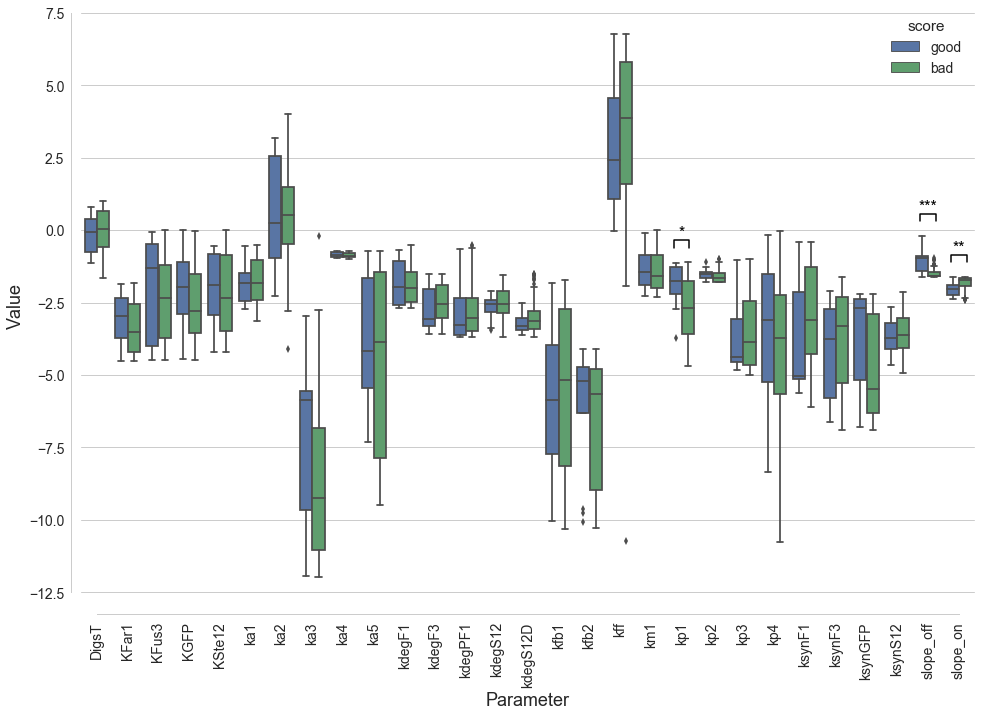

In [36]:
# plot box plot comparing parameter sets for MAPK

labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']

d = []
e = []
arr_best_inds_P=arr_best_inds_P
for i in range(len(arr_best_inds_P)):
    if MAPK_bool[i]==1:
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    else:
        e.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})
    

swarm_params_good = pd.DataFrame(d)
swarm_params_bad = pd.DataFrame(e)

unstacked_good = swarm_params_good.unstack().reset_index() 
unstacked_good.columns = ['Parameter', 'index', 'Value']

unstacked_bad = swarm_params_bad.unstack().reset_index() 
unstacked_bad.columns = ['Parameter', 'index', 'Value']

# Get p-valuses
p_vals = []
for i in swarm_params_good.columns:
    p_vals.append(stats.ttest_ind(swarm_params_good[i],swarm_params_bad[i])[1])
    
# Create comparison data frame
compare = pd.concat([unstacked_good, unstacked_bad], keys=['good', 'bad'])
compare = compare.reset_index();
compare = compare.rename(columns={'level_0':'score'})

# Make a box plot comparing parameter sets
fig = plt.figure(figsize=(16, 11))
g=sns.boxplot(x="Parameter", y="Value",
            hue="score", data=compare);
for i in range(len(p_vals)):
    if p_vals[i] < 0.001:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.01:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 16)
    elif p_vals[i] < 0.05:
        x1, x2 = i-.25, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Value'].max()+0.5, 0.25, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 16)
sns.despine(offset=10, trim=True)
g.set_xticklabels(labelnames,rotation=90);
fig.savefig('Digs box.png',dpi = 600)

# New model fits with reduced ranges

In [26]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181105_AllDatav3_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.1)
arrT_best_inds_P = arr_best_inds_P.transpose()

Loaded 98 files (out of 250) with cutoff score of 1.1


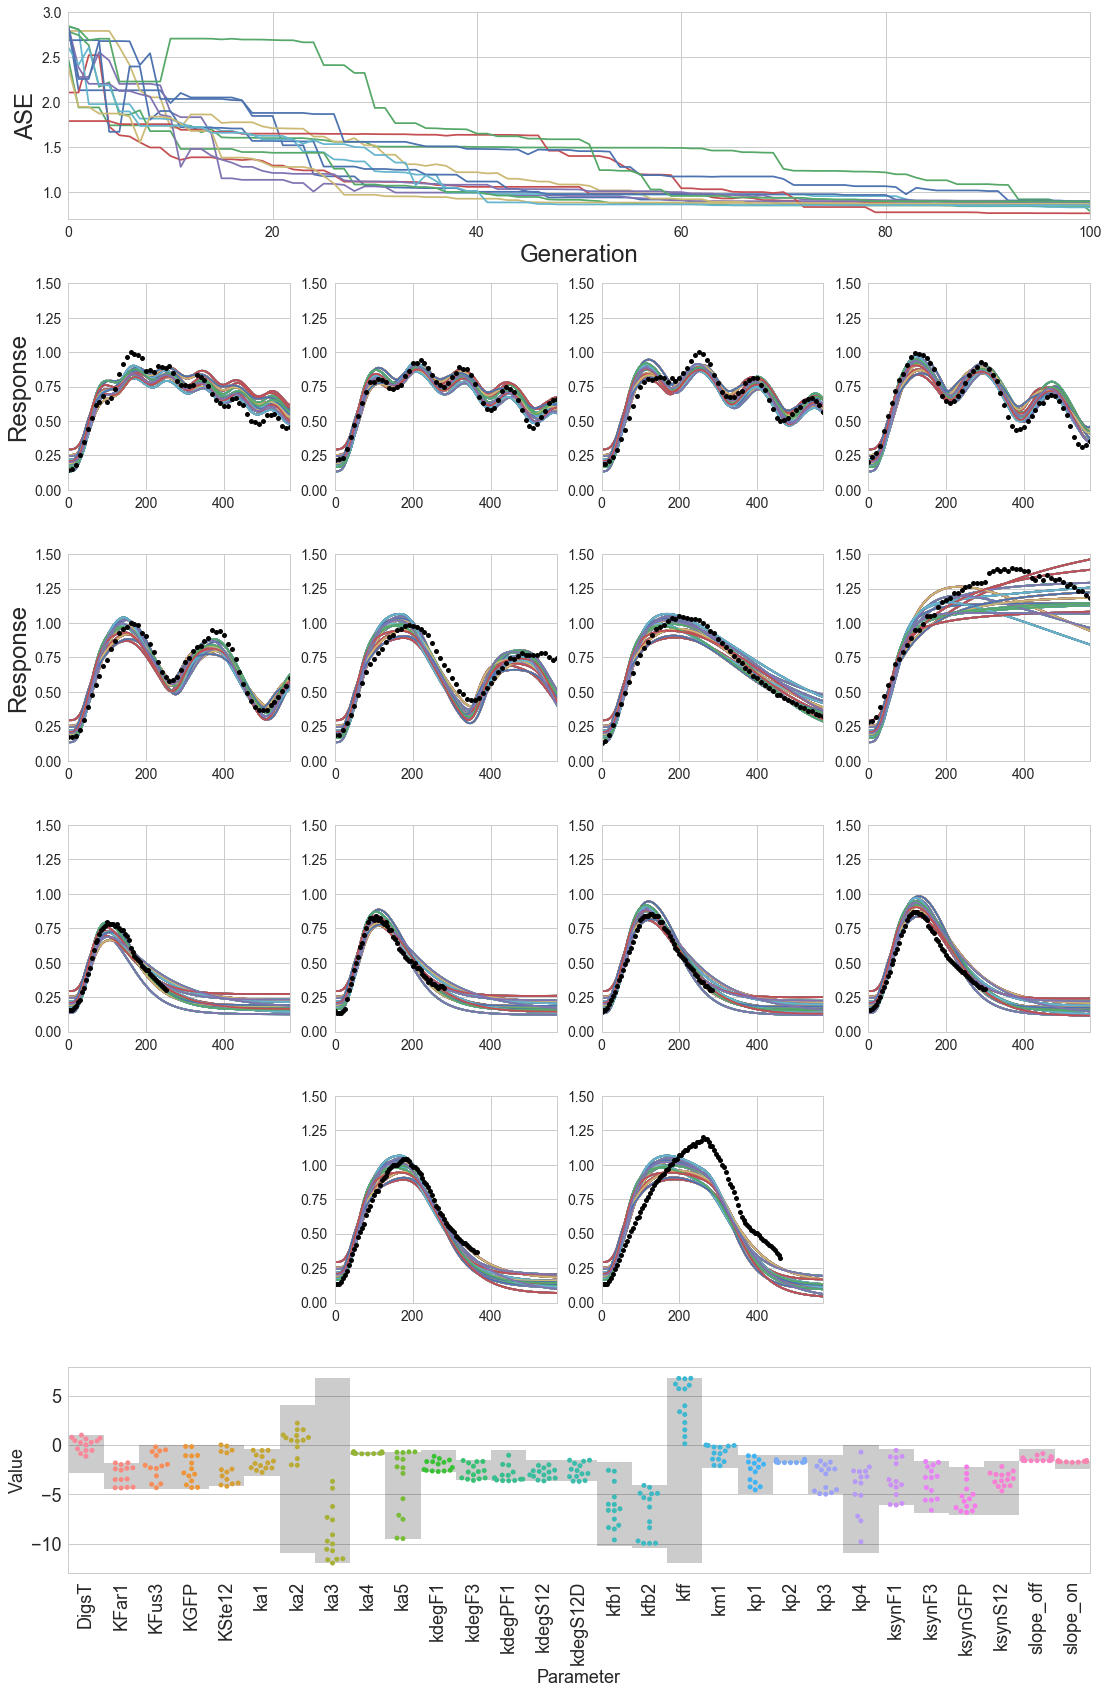

In [17]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2],  
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    ax1.set_ylim([0.7,3.0])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.2,-3.2,-11,-12,-1.0,-9.5,-2.7,-3.6,-3.7,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-1.8,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.4]
    maxes = [1,-1.8,0,0,0,-0.4,4,6.8,-0.7,-0.7,-0.5,-1.5,-0.5,-1.5,-1.5,-1.7,-4.1,6.8,0,-1,-1,-1,0,-0.4,-1.6,-2.2,-1.6,-0.4,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
fig.savefig('New Model narrow parameters.png',dpi = 600)
